<a href="https://colab.research.google.com/github/ksushrut/CoinClassifier/blob/main/Models_SushrutPhase2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import zipfile

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp -r "/content/drive/My Drive/CoinImages/compressed" /content/

In [8]:
import zipfile
import os

# Path to your uploaded zip file
zip_path = "/content/compressed/PreprocessedCoinImages.zip"

# Destination directory
extract_dir = "/content/PreprocessedCoinImages"

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Files extracted to: {extract_dir}")

Files extracted to: /content/PreprocessedCoinImages


In [9]:
csv_loc='https://raw.githubusercontent.com/ksushrut/CoinClassifier/refs/heads/main/processed_data.csv'

In [10]:
df=pd.read_csv(csv_loc)
df

,URL,image name,country,width,height,label
0,/content/drive/My Drive/CoinImages/Preprocesse...,14t.jpg,Australia,224,224,AUD 50 Cents
1,/content/drive/My Drive/CoinImages/Preprocesse...,10t.jpg,Australia,224,224,AUD 50 Cents
2,/content/drive/My Drive/CoinImages/Preprocesse...,13t.jpg,Australia,224,224,AUD 50 Cents
3,/content/drive/My Drive/CoinImages/Preprocesse...,3h.jpg,Australia,224,224,AUD 50 Cents
4,/content/drive/My Drive/CoinImages/Preprocesse...,2h.jpg,Australia,224,224,AUD 50 Cents
...,...,...,...,...,...,...
2418,/content/drive/My Drive/CoinImages/Preprocesse...,4h.jpeg,India,224,224,INR 10Rs
2419,/content/drive/My Drive/CoinImages/Preprocesse...,24h.jpeg,India,224,224,INR 10Rs
2420,/content/drive/My Drive/CoinImages/Preprocesse...,11t.jpeg,India,224,224,INR 10Rs
2421,/content/drive/My Drive/CoinImages/Preprocesse...,3h.jpeg,India,224,224,INR 10Rs


In [11]:
label_encoder = LabelEncoder()
df['encoded_class'] = label_encoder.fit_transform(df['label'])

In [12]:
df['URL'] = df['URL'].str.replace("/content/drive/My Drive/CoinImages/Preprocessed_Images",
                                  "/content/PreprocessedCoinImages")

In [13]:
df

,URL,image name,country,width,height,label,encoded_class
0,/content/drive/My Drive/CoinImages/Preprocesse...,14t.jpg,Australia,224,224,AUD 50 Cents,23
1,/content/drive/My Drive/CoinImages/Preprocesse...,10t.jpg,Australia,224,224,AUD 50 Cents,23
2,/content/drive/My Drive/CoinImages/Preprocesse...,13t.jpg,Australia,224,224,AUD 50 Cents,23
3,/content/drive/My Drive/CoinImages/Preprocesse...,3h.jpg,Australia,224,224,AUD 50 Cents,23
4,/content/drive/My Drive/CoinImages/Preprocesse...,2h.jpg,Australia,224,224,AUD 50 Cents,23
...,...,...,...,...,...,...,...
2418,/content/drive/My Drive/CoinImages/Preprocesse...,4h.jpeg,India,224,224,INR 10Rs,32
2419,/content/drive/My Drive/CoinImages/Preprocesse...,24h.jpeg,India,224,224,INR 10Rs,32
2420,/content/drive/My Drive/CoinImages/Preprocesse...,11t.jpeg,India,224,224,INR 10Rs,32
2421,/content/drive/My Drive/CoinImages/Preprocesse...,3h.jpeg,India,224,224,INR 10Rs,32


In [14]:
df_sushrut = df[(df['country'] == 'India') | (df['country'] == 'United States')].reset_index(drop=True)

In [15]:
class CoinImageDataset(Dataset):
    def __init__(self, dataframe,transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform=transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_folder = row['URL']
        img_name = str(row['image name']).strip()
        img_path = img_folder +'/'+ img_name
        label = row['encoded_class']

        image = Image.open(img_path).convert("RGB")
        image = torch.tensor(np.array(image)).permute(2, 0, 1).float() / 255.0
        return image, label

In [16]:
train_df, val_test_df = train_test_split(df, test_size=0.4, random_state=42, stratify=df['encoded_class'])
val_df, test_df = train_test_split(val_test_df, test_size=0.75,
random_state=42, stratify=val_test_df['encoded_class'])

train_dataset = CoinImageDataset(train_df)
val_dataset = CoinImageDataset(val_df)
test_dataset = CoinImageDataset(test_df)


train_loader = DataLoader(train_dataset, batch_size=32,
shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [17]:
sushruttrain_df, sushrutval_test_df = train_test_split(df_sushrut, test_size=0.4, random_state=42, stratify=df_sushrut['encoded_class'])
sushrutval_df, sushruttest_df = train_test_split(sushrutval_test_df, test_size=0.75,
random_state=42, stratify=sushrutval_test_df['encoded_class'])

train_dataset = CoinImageDataset(train_df)
val_dataset = CoinImageDataset(val_df)
test_dataset = CoinImageDataset(test_df)

sushrut_train_loader = DataLoader(train_dataset, batch_size=32,
shuffle=True)
sushrut_val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
sushrut_test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [18]:
def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= total
    val_acc = 100 * correct / total
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%\n")
    model.train()
    return val_acc

In [19]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device,scheduler, num_epochs=10):
    lrs=[]
    train_acc=[]
    val_acc=[]

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        print(f"Epoch {epoch+1}/{num_epochs}")

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = 100 * correct / total
        print(f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.2f}%")
        val_accuracy=validate_model(model, val_loader, criterion, device)
        scheduler.step()
        train_acc.append(epoch_acc)
        val_acc.append(val_accuracy)
        lrs.append(optimizer.param_groups[0]['lr'])
    return lrs,train_acc,val_acc

In [20]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_loss /= total
    test_acc = 100 * correct / total
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")

# AlexNet FineTuning

In [35]:
import torch
import torch.nn as nn
from torchvision import models

class AlexNetFineTuner(nn.Module):
    def __init__(self, num_classes):
        super(AlexNetFineTuner, self).__init__()
        self.alexnet = models.alexnet(pretrained=True)

        for idx in [1, 3]:
            for param in self.alexnet.classifier[idx].parameters():
                param.requires_grad = False
        self.alexnet.classifier[6] = nn.Linear(self.alexnet.classifier[6].in_features, num_classes)

    def forward(self, x):
        return self.alexnet(x)

In [42]:
num_classes = df['encoded_class'].nunique()
print("Number of classes",num_classes)
alex_finetunemodel = AlexNetFineTuner(num_classes=num_classes)
print(alex_finetunemodel)

Number of classes 48


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNetFineTuner(
  (alexnet): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False

In [43]:
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
alex_finetunemodel.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alex_finetunemodel.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

lrs,train_acc,val_acc=train_model(alex_finetunemodel, train_loader, sushrut_val_loader, criterion, optimizer,device, scheduler)
# Save the model after training
torch.save(alex_finetunemodel.state_dict(), 'alex_finetunemodel.pth')
print("Model saved as 'alex_finetunemodel.pth'")

Epoch 1/10
Train Loss: 3.6591 | Train Acc: 9.98%
Val Loss: 2.9053 | Val Acc: 27.27%

Epoch 2/10
Train Loss: 2.3180 | Train Acc: 39.02%
Val Loss: 1.8588 | Val Acc: 50.83%

Epoch 3/10
Train Loss: 1.3707 | Train Acc: 59.74%
Val Loss: 1.4782 | Val Acc: 59.09%

Epoch 4/10
Train Loss: 0.7725 | Train Acc: 76.94%
Val Loss: 1.2710 | Val Acc: 61.98%

Epoch 5/10
Train Loss: 0.4762 | Train Acc: 85.48%
Val Loss: 1.1670 | Val Acc: 67.36%

Epoch 6/10
Train Loss: 0.2398 | Train Acc: 92.98%
Val Loss: 1.0213 | Val Acc: 71.07%

Epoch 7/10
Train Loss: 0.1374 | Train Acc: 96.70%
Val Loss: 1.0953 | Val Acc: 72.31%

Epoch 8/10
Train Loss: 0.1065 | Train Acc: 97.38%
Val Loss: 1.2148 | Val Acc: 71.90%

Epoch 9/10
Train Loss: 0.0945 | Train Acc: 96.77%
Val Loss: 1.2451 | Val Acc: 69.83%

Epoch 10/10
Train Loss: 0.0748 | Train Acc: 98.07%
Val Loss: 1.2617 | Val Acc: 69.83%

Model saved as 'alex_finetunemodel.pth'


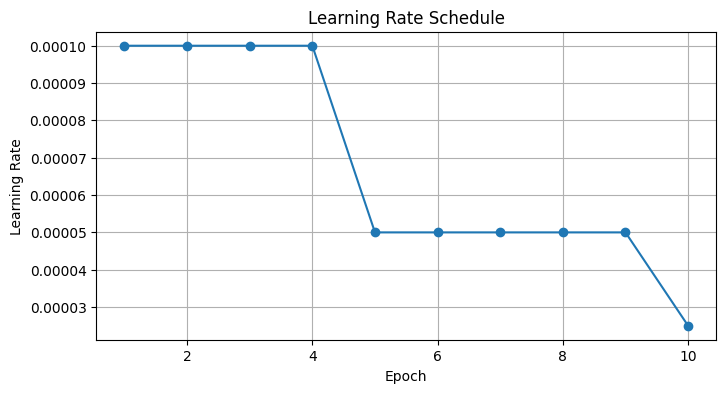

In [44]:
plt.figure(figsize=(8, 4))
plt.plot(range(1,11), lrs, marker='o')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

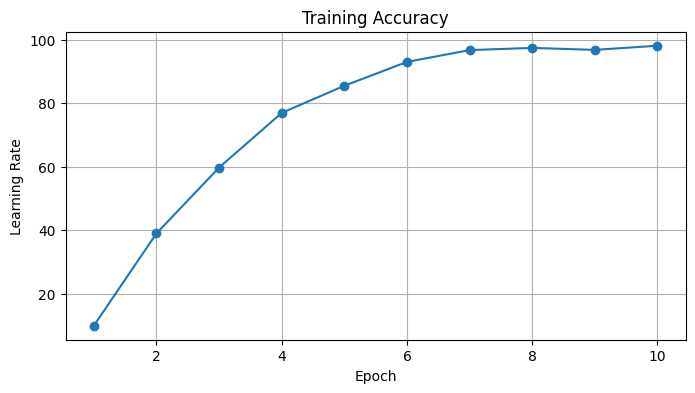

In [45]:
plt.figure(figsize=(8, 4))
plt.plot(range(1,11), train_acc, marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

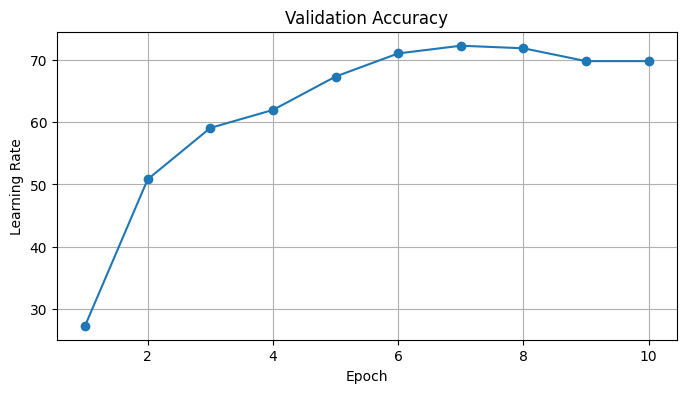

In [46]:
plt.figure(figsize=(8, 4))
plt.plot(range(1,11), val_acc, marker='o')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

In [47]:
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
alex_finetunemodel.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alex_finetunemodel.parameters(), lr=1e-4)
alex_finetunemodel.eval()  # Set the model to evaluation mode
test_model(alex_finetunemodel, sushrut_test_loader, criterion, device)

Test Loss: 1.1583 | Test Accuracy: 72.25%


# VCG FineTuning

In [21]:
import torch
import torch.nn as nn
from torchvision import models

class PretrainedVGG16(nn.Module):
    def __init__(self, num_classes,freeze_features=True):
        super(PretrainedVGG16, self).__init__()
        self.vgg = models.vgg16(pretrained=True)

        for idx in [1,2,3,4,5]:
            for param in self.vgg.classifier[idx].parameters():
                param.requires_grad = False

        self.vgg.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        return self.vgg(x)

In [22]:
num_classes = df['encoded_class'].nunique()
print("Number of classes",num_classes)
vgg_finetunedmodel = PretrainedVGG16(num_classes=num_classes)
print(vgg_finetunedmodel)

Number of classes 48


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 112MB/s] 


PretrainedVGG16(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

In [23]:
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg_finetunedmodel.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_finetunedmodel.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

lrs,train_acc,val_acc=train_model(vgg_finetunedmodel, train_loader, sushrut_val_loader, criterion, optimizer,device, scheduler)
# Save the model after training
torch.save(vgg_finetunedmodel.state_dict(), 'vgg_finetunemodel.pth')
print("Model saved as 'vgg_finetunemodel.pth'")

Epoch 1/10
Train Loss: 3.3898 | Train Acc: 14.38%
Val Loss: 1.8300 | Val Acc: 54.13%

Epoch 2/10
Train Loss: 1.4657 | Train Acc: 58.91%
Val Loss: 1.0137 | Val Acc: 74.38%

Epoch 3/10
Train Loss: 0.6151 | Train Acc: 81.62%
Val Loss: 0.8631 | Val Acc: 73.14%

Epoch 4/10
Train Loss: 0.3843 | Train Acc: 88.58%
Val Loss: 0.7729 | Val Acc: 78.93%

Epoch 5/10
Train Loss: 0.2595 | Train Acc: 92.22%
Val Loss: 0.8584 | Val Acc: 76.45%

Epoch 6/10
Train Loss: 0.1355 | Train Acc: 95.66%
Val Loss: 0.6778 | Val Acc: 83.47%

Epoch 7/10
Train Loss: 0.0462 | Train Acc: 98.42%
Val Loss: 0.9108 | Val Acc: 79.34%

Epoch 8/10
Train Loss: 0.0508 | Train Acc: 98.55%
Val Loss: 0.7181 | Val Acc: 83.47%

Epoch 9/10
Train Loss: 0.0468 | Train Acc: 98.62%
Val Loss: 0.8789 | Val Acc: 80.99%

Epoch 10/10
Train Loss: 0.0259 | Train Acc: 99.04%
Val Loss: 0.8778 | Val Acc: 83.47%

Model saved as 'vgg_finetunemodel.pth'


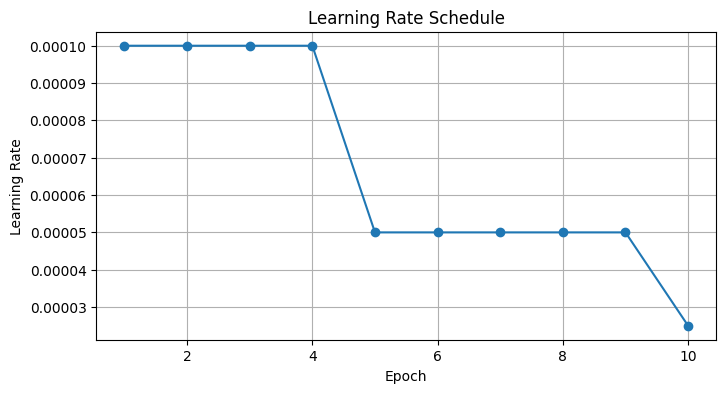

In [24]:
plt.figure(figsize=(8, 4))
plt.plot(range(1,11), lrs, marker='o')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

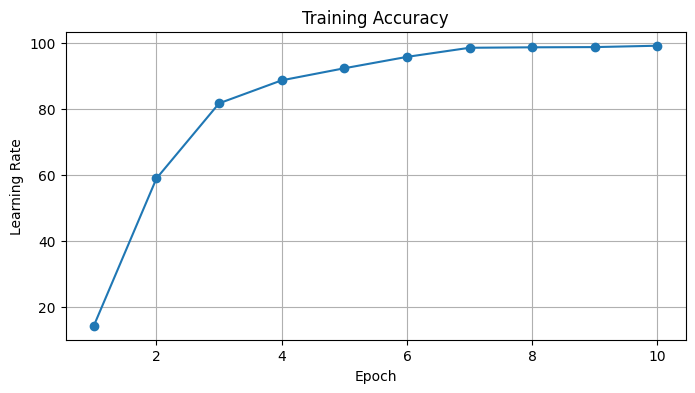

In [25]:
plt.figure(figsize=(8, 4))
plt.plot(range(1,11), train_acc, marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

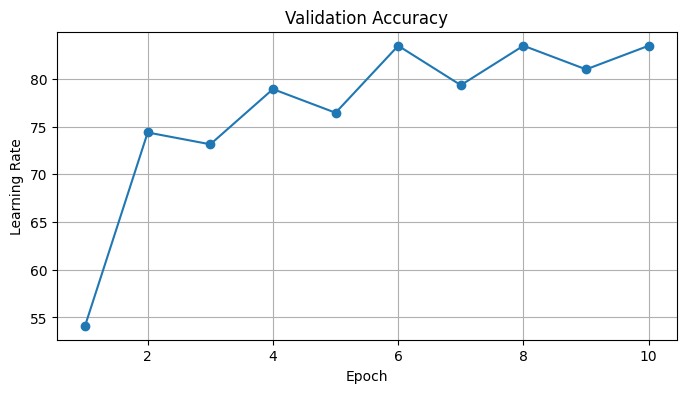

In [26]:
plt.figure(figsize=(8, 4))
plt.plot(range(1,11), val_acc, marker='o')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

In [27]:
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg_finetunedmodel.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_finetunedmodel.parameters(), lr=1e-4)
vgg_finetunedmodel.eval()  # Set the model to evaluation mode
test_model(vgg_finetunedmodel, sushrut_test_loader, criterion, device)

Test Loss: 0.7443 | Test Accuracy: 84.89%


# Augmentation

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),                         # Resize to standard input size
    transforms.RandomHorizontalFlip(p=0.2),                # Mild flipping
    transforms.RandomRotation(degrees=5),                  # Small rotation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4785, 0.5099, 0.5338],
                         std=[0.2261, 0.2196, 0.2504])
])

In [32]:
train_dataset = CoinImageDataset(train_df, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [33]:
sushruttrain_df, sushrutval_test_df = train_test_split(df_sushrut, test_size=0.4, random_state=42, stratify=df_sushrut['encoded_class'])
sushrutval_df, sushruttest_df = train_test_split(sushrutval_test_df, test_size=0.75,
random_state=42, stratify=sushrutval_test_df['encoded_class'])

train_dataset = CoinImageDataset(train_df,transform=train_transforms)
val_dataset = CoinImageDataset(val_df,transform=train_transforms)
test_dataset = CoinImageDataset(test_df,transform=train_transforms)

sushrut_train_loader = DataLoader(train_dataset, batch_size=32,
shuffle=True)
sushrut_val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
sushrut_test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [36]:
alex_finetunemodel = AlexNetFineTuner(num_classes=num_classes)
print(alex_finetunemodel)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 182MB/s]


AlexNetFineTuner(
  (alexnet): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False

In [37]:
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
alex_finetunemodel.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alex_finetunemodel.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

lrs,train_acc,val_acc=train_model(alex_finetunemodel, train_loader, sushrut_val_loader, criterion, optimizer,device, scheduler)
# Save the model after training
torch.save(alex_finetunemodel.state_dict(), 'alex_finetunemodel.pth')
print("Model saved as 'alex_finetunemodel.pth'")

Epoch 1/10
Train Loss: 3.7343 | Train Acc: 7.23%
Val Loss: 3.0736 | Val Acc: 22.31%

Epoch 2/10
Train Loss: 2.5084 | Train Acc: 32.62%
Val Loss: 1.9455 | Val Acc: 49.59%

Epoch 3/10
Train Loss: 1.4447 | Train Acc: 59.39%
Val Loss: 1.5270 | Val Acc: 60.33%

Epoch 4/10
Train Loss: 0.8740 | Train Acc: 73.57%
Val Loss: 1.1569 | Val Acc: 69.01%

Epoch 5/10
Train Loss: 0.5697 | Train Acc: 82.73%
Val Loss: 1.1228 | Val Acc: 69.83%

Epoch 6/10
Train Loss: 0.2695 | Train Acc: 92.36%
Val Loss: 1.0574 | Val Acc: 72.31%

Epoch 7/10
Train Loss: 0.1648 | Train Acc: 94.98%
Val Loss: 1.1311 | Val Acc: 72.31%

Epoch 8/10
Train Loss: 0.1449 | Train Acc: 95.94%
Val Loss: 1.1440 | Val Acc: 71.90%

Epoch 9/10
Train Loss: 0.1081 | Train Acc: 97.25%
Val Loss: 1.1596 | Val Acc: 73.14%

Epoch 10/10
Train Loss: 0.0827 | Train Acc: 97.52%
Val Loss: 1.2175 | Val Acc: 73.55%

Model saved as 'alex_finetunemodel.pth'


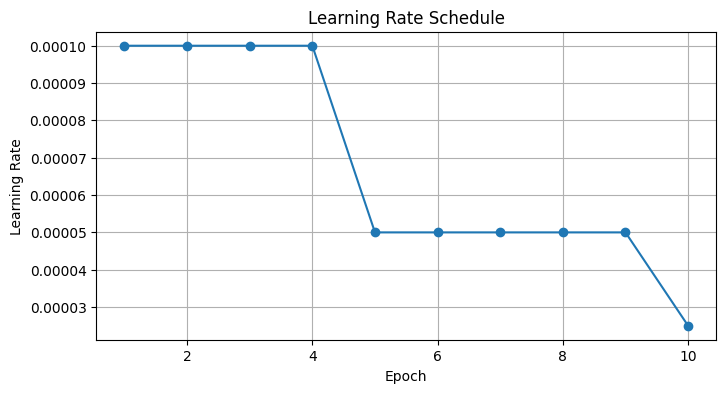

In [38]:
plt.figure(figsize=(8, 4))
plt.plot(range(1,11), lrs, marker='o')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

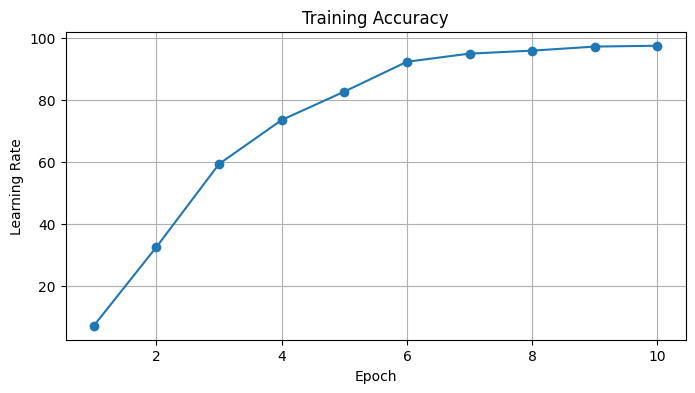

In [39]:
plt.figure(figsize=(8, 4))
plt.plot(range(1,11), train_acc, marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

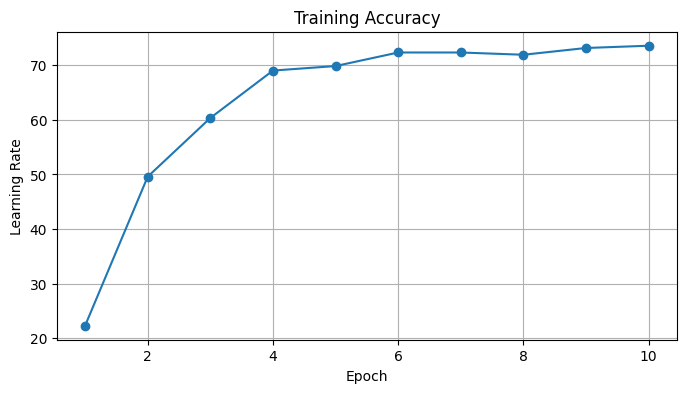

In [40]:
plt.figure(figsize=(8, 4))
plt.plot(range(1,11), val_acc, marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

In [41]:
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
alex_finetunemodel.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alex_finetunemodel.parameters(), lr=1e-4)
alex_finetunemodel.eval()  # Set the model to evaluation mode
test_model(alex_finetunemodel, sushrut_test_loader, criterion, device)

Test Loss: 1.1262 | Test Accuracy: 71.98%


### VGG

In [48]:
vgg_model = PretrainedVGG16(num_classes=num_classes)
print(vgg_model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


PretrainedVGG16(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

In [50]:
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

lrs,train_acc,val_acc=train_model(vgg_model, train_loader, sushrut_val_loader, criterion, optimizer,device, scheduler)
# Save the model after training
torch.save(vgg_model.state_dict(), 'vgg_finetunemodel.pth')
print("Model saved as 'vgg_finetunemodel.pth'")

Epoch 1/10
Train Loss: 3.3888 | Train Acc: 16.93%
Val Loss: 1.8460 | Val Acc: 56.20%

Epoch 2/10
Train Loss: 1.4404 | Train Acc: 61.73%
Val Loss: 1.0773 | Val Acc: 72.73%

Epoch 3/10
Train Loss: 0.6306 | Train Acc: 82.52%
Val Loss: 0.8528 | Val Acc: 76.86%

Epoch 4/10
Train Loss: 0.3446 | Train Acc: 89.47%
Val Loss: 0.8344 | Val Acc: 80.17%

Epoch 5/10
Train Loss: 0.2213 | Train Acc: 92.77%
Val Loss: 1.0421 | Val Acc: 79.34%

Epoch 6/10
Train Loss: 0.1407 | Train Acc: 95.39%
Val Loss: 0.7925 | Val Acc: 82.23%

Epoch 7/10
Train Loss: 0.0774 | Train Acc: 97.66%
Val Loss: 0.7236 | Val Acc: 83.06%

Epoch 8/10
Train Loss: 0.0427 | Train Acc: 98.49%
Val Loss: 0.8142 | Val Acc: 83.06%

Epoch 9/10
Train Loss: 0.0453 | Train Acc: 98.90%
Val Loss: 0.9327 | Val Acc: 82.23%

Epoch 10/10
Train Loss: 0.0480 | Train Acc: 98.55%
Val Loss: 0.7977 | Val Acc: 82.64%

Model saved as 'vgg_finetunemodel.pth'


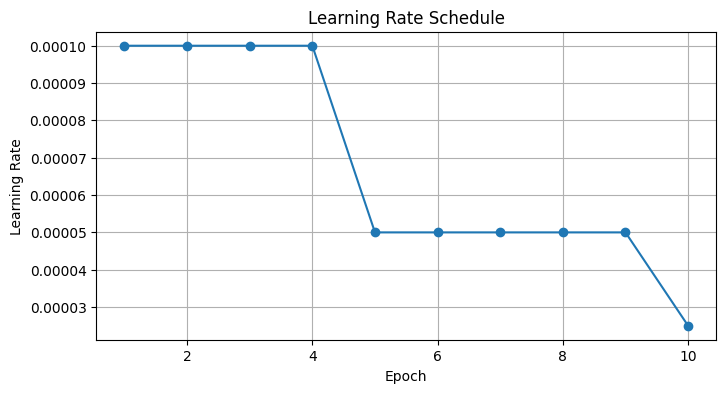

In [51]:
plt.figure(figsize=(8, 4))
plt.plot(range(1,11), lrs, marker='o')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

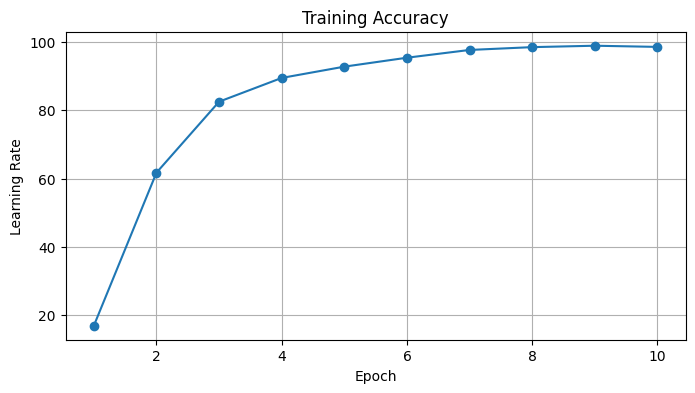

In [52]:
plt.figure(figsize=(8, 4))
plt.plot(range(1,11), train_acc, marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

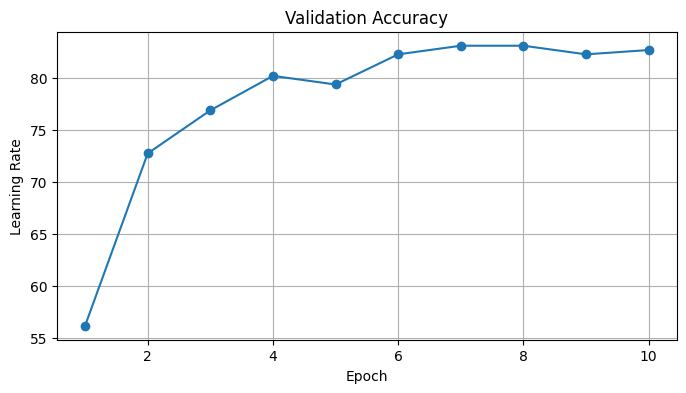

In [53]:
plt.figure(figsize=(8, 4))
plt.plot(range(1,11), val_acc, marker='o')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

In [55]:
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_model.parameters(), lr=1e-4)
vgg_finetunedmodel.eval()  # Set the model to evaluation mode
test_model(vgg_model, sushrut_test_loader, criterion, device)

Test Loss: 0.7398 | Test Accuracy: 84.20%


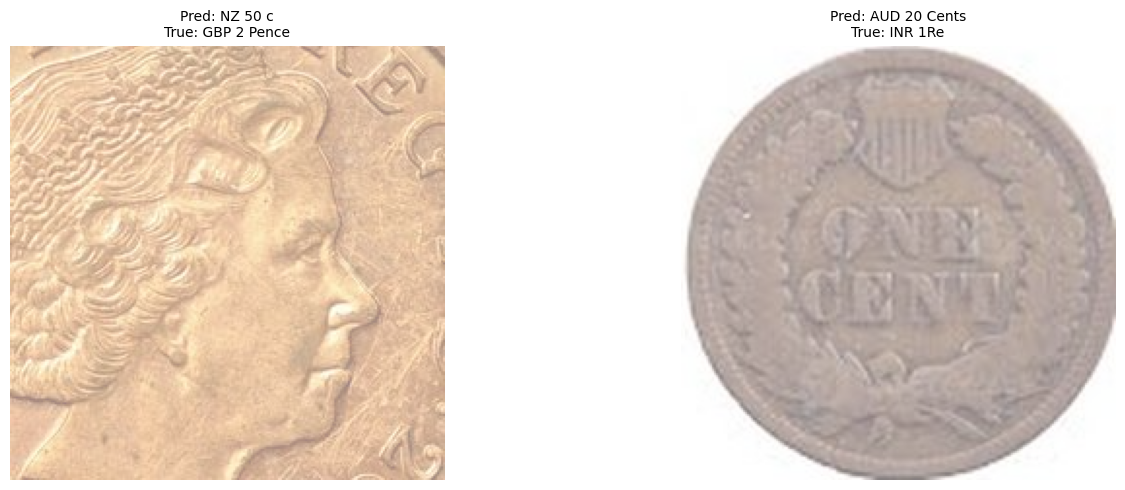

In [80]:
import matplotlib.pyplot as plt
import torch
import torchvision

def show_misclassified(model, dataloader, device, classes, max_images=10):
    model.eval()
    misclassified = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    misclassified.append((images[i].cpu(), preds[i].cpu(), labels[i].cpu()))
                if len(misclassified) >= max_images:
                    break
            if len(misclassified) >= max_images:
                break

    # Plot
    fig, axes = plt.subplots(1, len(misclassified), figsize=(15, 5))
    if len(misclassified) == 1:
        axes = [axes]  # ensure axes is iterable

    for idx, (img, pred, label) in enumerate(misclassified):
        img = img.permute(1, 2, 0)  # CHW to HWC
        img = img * 0.5 + 0.5       # de-normalize if you used transforms.Normalize
        axes[idx].imshow(img.numpy())
        axes[idx].axis('off')
        axes[idx].set_title(f'Pred: {classes[pred]}\nTrue: {classes[label]}', fontsize=10)

    plt.tight_layout()
    plt.show()

show_misclassified(vgg_model,sushrut_val_loader, device, df['label'].unique(), max_images=2)